In [358]:
from tqdm import tqdm
import torch

import torch_scatter
import torch_geometric
verbose = True

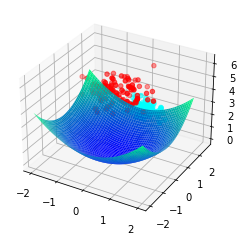

In [359]:
# show some 3d-point cloud data.
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import torch.nn as nn
import numpy as np

class Id(nn.Module):
    def __init__(self):super().__init__()
    def forward(self, x):return x

fig = plt.figure()
ax = plt.axes(projection = '3d')

scale = 2
x = torch.linspace(-1, 1, 100) * scale
y = torch.linspace(-1, 1, 100) * scale
X,Y = torch.meshgrid(x,y)
Z = X**2 + Y**2 

#ax.plot_surface(X,Y,Z, cmap = "rainbow")

ax.plot_surface(X,Y,Z * 0.5, cmap = "winter")

N = 100
x_points = torch.randn([N, 3]) * 0.5 + torch.tensor([-0.,-0,5]).unsqueeze(0).repeat([N,1])
y_points = torch.randn([N, 3]) * 0.3 + torch.tensor([0.2,2,2]).unsqueeze(0).repeat([N,1])


ax.scatter(x_points[:,0], x_points[:,1], x_points[:,2], color = "red")
ax.scatter(y_points[:,0], y_points[:,1], y_points[:,2], color = "cyan")

plt.show()


/var/folders/tp/c2bzzvd17y35z8x_20mfhn700000gn/T/ipykernel_32592/2308678624.py:13: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax=Axes3D(fig)


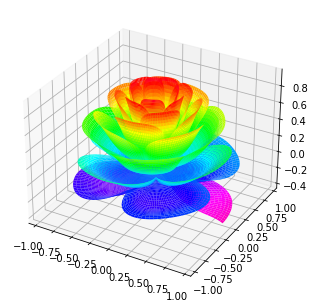

In [360]:
from mpl_toolkits.mplot3d import Axes3D

from matplotlib import cm

from matplotlib.ticker import LinearLocator

import matplotlib.pyplot as plt

import numpy as np

fig=plt.figure()

ax=Axes3D(fig)
#ax = axes3d.Axes3D(fig)

[x,t]=np.meshgrid(np.array(range(25))/24.0,np.arange(0,575.5,0.5)/575*17*np.pi-2*np.pi)

p=(np.pi/2)*np.exp(-t/(8*np.pi))

u=1-(1-np.mod(3.6*t,2*np.pi)/np.pi)**4/2

y=2*(x**2-x)**2*np.sin(p)

r=u*(x*np.sin(p)+y*np.cos(p))

surf=ax.plot_surface(r*np.cos(t),r*np.sin(t),u*(x*np.cos(p)-y*np.sin(p)),rstride=1,cstride=1,cmap=cm.gist_rainbow_r,

                  linewidth=0,antialiased=True)

plt.show()


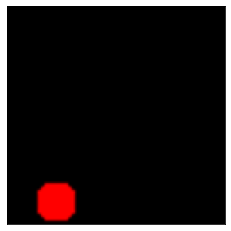

In [361]:
from datasets import *
from models import *
from config import *

node_feat_size = 64
graph_prop_iters = 7
GraphPropagation(num_iters = graph_prop_iters)

grid_convs = RDN(SimpleNamespace(G0=node_feat_size  ,RDNkSize=3,n_colors=3,
                               RDNconfig=(4,3,16),scale=[2],no_upsampling=True))

test_dataset = SpriteData(split = "train")
dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = 1, shuffle = True)

for sample in dataloader:
    ims = sample["image"]
    break;

B, W, H, C = ims.shape
# show the image data to test
plt.figure("input-data", frameon = False,)

for b in range(B):
    plt.subplot(1, B, b + 1);plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False); plt.imshow(ims[b,:,:,:])
plt.show()

In [362]:
imsize = 128
perception_size = 12

# build the connection graph for the grid domain
spatial_edges, spatial_coords = grid(imsize,imsize,device=device)
spaital_edges =  build_perception(imsize,perception_size,device = device)

# flatten the image-feature and add it with the coordinate information
im_feats = grid_convs(ims.permute([0,3,1,2])) # [B,D,W,H]

coords_added_im_feats = im_feats.flatten(2,3).permute(0,2,1) # 【B, N, D】
weights = torch.ones(spatial_edges.shape[1])


graph_in = Batch.from_data_list([Data(x, spatial_edges, edge_attr = {"weights":weights})
                                                for x in coords_added_im_feats])


print(graph_in.x.shape)
print(graph_in.edge_index.shape)
print(graph_in.edge_attr["weights"].shape)


def l2_normalize(x): return torch.nn.functional.normalize(x, p=2.0, dim = -1, eps = 1e-6)

def reduce_max(x, dim, keepdim = True): return torch.max(x, dim = dim, keepdim = keepdim)[0]


torch.Size([16384, 64])
torch.Size([2, 145924])
torch.Size([145924])


In [363]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_planes, planes, norm_fn='group', kernel_size=3, stride=1, residual=True, bias=True, downsample=False):
        super(ResidualBlock, self).__init__()

        padding = 1 if kernel_size == 3 else 0
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=kernel_size, bias=bias, padding=padding, stride=stride)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=kernel_size, bias=bias, padding=padding)
        self.relu = nn.ReLU(inplace=True)

        num_groups = planes // 8

        if norm_fn == 'group':
            self.norm1 = nn.GroupNorm(num_groups=num_groups, num_channels=planes)
            self.norm2 = nn.GroupNorm(num_groups=num_groups, num_channels=planes)
            if not stride == 1 or downsample is True:
                self.norm3 = nn.GroupNorm(num_groups=num_groups, num_channels=planes)

        elif norm_fn == 'batch':
            self.norm1 = nn.BatchNorm2d(planes)
            self.norm2 = nn.BatchNorm2d(planes)
            if not stride == 1 or downsample is True:
                self.norm3 = nn.BatchNorm2d(planes)

        elif norm_fn == 'instance':
            self.norm1 = nn.InstanceNorm2d(planes)
            self.norm2 = nn.InstanceNorm2d(planes)
            if not stride == 1 or downsample is True:
                self.norm3 = nn.InstanceNorm2d(planes)

        elif norm_fn == 'none':
            self.norm1 = nn.Sequential()
            self.norm2 = nn.Sequential()
            if not stride == 1 or downsample is True:
                self.norm3 = nn.Sequential()

        if stride == 1 and not downsample:
            self.shortcut = None

        else:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=bias), self.norm3)

        self.residual = residual

    def forward(self, x):
        y = x
        y = self.relu(self.norm1(self.conv1(y)))
        y = self.norm2(self.conv2(y))

        if not self.residual:
            return y

        if self.shortcut is not None:
            x = self.shortcut(x)

        return self.relu(x+y)

In [364]:
# [Scene Structure]

def to_base(indices, edges):
    """
    input:
        indices: [K]
        edges: [N,2]
    outputs:
        base_indices: [L]
    """
    base_indices = []
    for i in range(edges.shape[0]): 
        if (edges[i][0] in indices): base_indices.append(i)
    return base_indices

def location_in_node(scene, node):
    return False

class SceneStructure:
    def __init__(self, graph, scores, from_base = None, base = None):
        self.graph = graph
        self.features = graph.x # [N, D]
        self.scores   = scores # [N, 1]
        self.edge_affinities = graph.edge_attr["weights"] #[N, N]
        self.from_base = from_base # [2,N]: [[1, 3],[1, 1]]
        self.base = base # Base Level Scene Structure
    
    def is_base(self): return self.from_base is None

    def locate_in(self, pos, node_indices):return 0

    def compute_masks(self, indices):
         # input: indices of nodes that need to compute mask
         # matrix form version.
        nodes = to_base(indices, self.from_base)
        if self.is_base():return self.scores[nodes]
        return self.base.compute_masks(nodes)

    def sparse_compute_masks(self, indices): 
        # input: indices of nodes that need to compute mask
        nodes = []
        for a in self.from_base.permute([1,0]):
            if a[1] in indices: nodes.append(a[0])
        if self.is_base():
            # this is the base level, just return the corresponding nodes
            return self.scores[nodes]
        return  self.base.compute_masks(nodes)

In [365]:
# may be we need a new graph propagation module

class GraphPropagator(nn.Module):
    def __init__(self, num_iters = 10, excite = True, inhibit = True, project = False, adj_thresh = 0.5):
        super().__init__()
        self.num_iters = num_iters
        self.excite = excite
        self.inhibit = inhibit
        self.project = project
        self.adj_thresh = adj_thresh
    
    @staticmethod
    def _threshold(x, thresh):
        return x * (x > thresh).float()

    @staticmethod
    def _threshold_sparse_tensor(x, thresh):
        row, col, value = x.coo()
        valid = value > thresh
        sparse_size = [x.size(0), x.size(1)]
        output = SparseTensor(row=row[valid],col=col[valid],value=value[valid],sparse_sizes=sparse_size)
        return output

    @staticmethod
    def _projection(v, u, eps=1e-12):
        u_norm = torch.sum(u * u, -1, keepdims=True)
        dot_prod = torch.sum(v * u, -1, keepdims=True)
        proj = (dot_prod / (u_norm + eps)) * u
        return proj

    @staticmethod
    def _relu_norm(x, relu=True, norm=True, eps=1e-16):
        x = F.relu(x) if relu else x
        x = F.normalize(x + eps, p=2.0, dim=-1, eps=max([eps, 1e-12])) if norm else x
        return x

    def excitory(self, weights, thresh = 0.5):
        return weights * (weights >= thresh)
    def inhibitory(self, weights, thresh = 0.5):
        return weights * (weights < thresh)

    def forward(self, state, edge_index, weights):
        state = self._relu_norm(state)
        weights = weights.unsqueeze(-1)
        for _ in range(9):
            state[edge_index[1,:],:] += self.excitory(weights, thresh = 0.5) * state[edge_index[0,:],:]
            state[edge_index[1,:],:] -= self.inhibitory(weights, thresh = 0.5) * state[edge_index[0,:],:]
            state = self._relu_norm(state)
        return state

    def propagate_step(self, state, h_e, h_i):
        return 0

class GraphPropagator(nn.Module):
    def __init__(self,
                 num_iters=15,
                 excite=True,
                 inhibit=True,
                 project=False,
                 adj_thresh=0.5):
        super().__init__()
        self.num_iters = num_iters
        self.excite = excite
        self.inhibit = inhibit
        self.project = project
        self.adj_thresh = adj_thresh

        self.adj_e = None
        self.adj_i = None
        self.norm_factor_e = None
        self.norm_factor_i = None
        self.activation_converge = False

    def preprocess_inputs(self, h0, adj, activated):
        B, N, K = h0.shape

        # activated: binary tensor indicating nodes to start propagation from
        if activated is None: # randomly initialized at a point
            rand_idx = torch.randint(0, N, [B, ]).to(h0.device)
            activated = F.one_hot(rand_idx, num_classes=N).unsqueeze(-1).float()  # [BT, N, 1]
        else:
            activated = activated.reshape(B, N, 1)

        # create excitatory and inhibitory affinities, followed by thresholding
        if not isinstance(adj, SparseTensor): # dense tensor
            adj = adj.reshape(B, N, N)
            adj_e, adj_i = adj, 1.0 - adj
            if self.adj_thresh is not None:
                adj_e = self._threshold(adj_e, self.adj_thresh)
                adj_i = self._threshold(adj_i, self.adj_thresh)
            sample_mask = None
        else: # sparse tensor
            adj_e = adj
            adj_i = adj.copy().set_value_(1.0 - adj.storage.value())

            sample_mask = adj_e.copy()
            sample_mask = sample_mask.set_value_(torch.ones_like(sample_mask.storage.value()))

            if self.adj_thresh is not None:
                adj_e = self._threshold_sparse_tensor(adj_e, self.adj_thresh)
                adj_i = self._threshold_sparse_tensor(adj_i, self.adj_thresh)

        return h0, adj_e, adj_i, activated, sample_mask
    def forward(self, h0, adj, activated=None):
        """
        Function: Graph propagation to create the plateau map representation
        Input:
        - h0: initial hidden states (or equivalently, plateau map representation) with shape [B, N Q]
        - adj: affinity matrix with shape
        - activated: The graph propagation will start from the activated nodes
                   It can be None or binary tensor of shape [B, N].
                   If None, one node will be randomly selected as being activated
        Return:
        - plateau_map_list: a list of plateau maps of len self.num_iters. Each plateau map has shape [B, N, Q]
        """

        h0, adj_e, adj_i, activated, sample_mask = self.preprocess_inputs(h0, adj, activated)

        h = h0.clone()
        plateau_map_list = []
        running_activated = activated
        self.activation_converge = False

        # start graph propagation
        for it in range(self.num_iters):
            h, activated, running_activated = \
                self.propagate(h, adj_e, adj_i, activated, running_activated, sample_mask, it)
            plateau_map_list.append(h.reshape(h0.shape))

        return plateau_map_list[-1]

    def propagate(self, h, adj_e, adj_i, activated, running_activated, sample_mask, iter):
        B, N, D = h.shape

        # Graph propagation starts at a subset of activated nodes
        # If self.activation_converge is False, i.e. not all nodes are activated, \
        #   we need to apply masking to the affinities and compute the normalization factor accordingly.
        # We do so until all the nodes are activated, i.e.  self.activation_converge == True

        if not self.activation_converge:
            if isinstance(adj_e, SparseTensor):
                # apply the activation mask on the affinity tensors
                adj_e = adj_e.mul(activated.flatten()[None])
                adj_i = adj_i.mul(activated.flatten()[None])
                sample_mask = sample_mask.mul(activated.flatten()[None])

            # compute the normalization factors
            if not isinstance(adj_e, SparseTensor):
                norm_factor_e = torch.sum(adj_e.abs() * activated, dim=-2, keepdim=True).clamp(min=1.0).detach()
                norm_factor_i = torch.sum(adj_i.abs() * activated, dim=-2, keepdim=True).clamp(min=1.0).detach()
            else:
                norm_factor_e = adj_e.sum(1).reshape(B, N, 1).clamp(min=1.0).detach()
                norm_factor_i = adj_i.sum(1).reshape(B, N, 1).clamp(min=1.0).detach()

            self.norm_factor_e = norm_factor_e # [B,1,N]
            self.norm_factor_i = norm_factor_i # [B,1,N]
            self.adj_e = adj_e
            self.adj_i = adj_i

            self.activation_converge = activated.sum() == (B * N)
        else: # no update is required if all the nodes are activated
            adj_e = self.adj_e
            adj_i = self.adj_i
            norm_factor_e = self.norm_factor_e
            norm_factor_i = self.norm_factor_i
            sample_mask = None

        # [Excitation]
        if self.excite:
            if not isinstance(adj_e, SparseTensor):
                e_effects = torch.matmul(h.permute(0, 2, 1), adj_e * activated) / norm_factor_e
                e_effects = e_effects.permute(0, 2, 1)
            else:
                e_effects = adj_e.matmul(h.reshape(B * N, D))
                e_effects = e_effects.reshape(B, N, D) / norm_factor_e
            h = h + e_effects

        # [Inhibition]
        if self.inhibit:
            if not isinstance(adj_e, SparseTensor):
                i_effects = torch.matmul(h.permute(0, 2, 1), adj_i * activated) / norm_factor_i
                i_effects = i_effects.permute(0, 2, 1)
            else:
                i_effects = adj_i.matmul(h.reshape(B * N, D))
                i_effects = i_effects.reshape(B, N, D) / norm_factor_i

            proj = self._projection(h, i_effects) if self.project else i_effects
            h = h - proj

        h = self._relu_norm(h)

        # [Update activated nodes]
        if activated.sum() < B * N:
            if not isinstance(adj_e, SparseTensor):
                receivers = torch.max(torch.where(adj_e > adj_i, adj_e, adj_i) * activated, dim=1, keepdim=False)[0] > 0.5 # [B,N]
            else:
                assert sample_mask is not None
                receivers = sample_mask.max(dim=1) > 0.5
                receivers = receivers.reshape(B, N)

            running_activated = running_activated + receivers.unsqueeze(-1).float()
            activated = running_activated.clamp(max=1.0).detach()

        return h, activated, running_activated

    @staticmethod
    def _threshold(x, thresh):
        return x * (x > thresh).float()

    @staticmethod
    def _threshold_sparse_tensor(x, thresh):
        row, col, value = x.coo()
        valid = value > thresh
        sparse_size = [x.size(0), x.size(1)]
        output = SparseTensor(row=row[valid],col=col[valid],value=value[valid],sparse_sizes=sparse_size)
        return output

    @staticmethod
    def _projection(v, u, eps=1e-12):
        u_norm = torch.sum(u * u, -1, keepdims=True)
        dot_prod = torch.sum(v * u, -1, keepdims=True)
        proj = (dot_prod / (u_norm + eps)) * u
        return proj

    @staticmethod
    def _relu_norm(x, relu=True, norm=True, eps=1e-16):
        x = F.relu(x) if relu else x
        x = F.normalize(x + eps, p=2.0, dim=-1, eps=max([eps, 1e-12])) if norm else x
        return x

In [366]:
from torch.nn import Linear, Parameter
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

class GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='add')  # "Add" aggregation (Step 5).
        self.lin = Linear(in_channels, out_channels, bias=False)
        self.bias = Parameter(torch.Tensor(out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        self.lin.reset_parameters()
        self.bias.data.zero_()

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # Step 1: Add self-loops to the adjacency matrix.
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Linearly transform node feature matrix.
        x = self.lin(x)

        # Step 3: Compute normalization.
        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Step 4-5: Start propagating messages.
        out = self.propagate(edge_index, x=x, norm=norm)

        # Step 6: Apply a final bias vector.
        out += self.bias

        return out

    def message(self, x_j, norm):
        # x_j has shape [E, out_channels]

        # Step 4: Normalize node features.
        return norm.view(-1, 1) * x_j

In [367]:
# write some util functions

import numpy as np

def sample_indices(batch, size, k_samples):
    max_index = size
    sample_index = []
    batch_index = []
    for b in range(batch):
        for k in range(k_samples): 
            sample_index.append(np.random.randint(max_index*b, max_index*(b+1)))
            batch_index.append(b)
    return sample_index, batch_index

def uniform_fully_connected(batch_size = 3, size = 30):
    assert size % batch_size == 0, print("full size cannot be batchify")
    full_edges = []
    for b in range(batch_size):
        for i in range(size // batch_size):
            for j in range(size // batch_size):full_edges.append([b * i,b * j])
    full_edges = torch.tensor(full_edges).t()
    return full_edges

# [Node Extraction]

class NodeExtraction(nn.Module):
    def __init__(self, k_nodes = 5, grid_size = 128*128):
        super().__init__()
        self.k_nodes = k_nodes
        self.grid_size = grid_size

    def forward(self,state, scene):
        """
        input: scene structure with
            x: node features [N, D]
            from_base: connection to the lower level
            locate_in(loc, node) -> bool
        output: at most k nodes from the 
        """
        node_features = state #[N,D]
        batch_size = scene.graph.batch.max() + 1

        #print(batch_size)
        sample_index, index_batch = sample_indices(batch_size, size = self.grid_size, k_samples = self.k_nodes)
        
        batch_node_mask = []
        for b in range(batch_size):
            #print(node_features.shape)
            sample_features = node_features[sample_index[self.k_nodes*b: self.k_nodes*(b+1)]]
            #print("location_feature_heads: ", sample_features.shape)
            #print("node_features:", node_features.shape)
            #masks = torch.einsum("nd,md->nm", sample_features, node_features)
            #print(sample_features.shape, node_features.shape)
            #print(torch.matmul(sample_features, node_features.permute(1,0)).max(),torch.matmul(sample_features, node_features.permute(1,0)).min())
            masks = torch.sigmoid(
                (torch.matmul(sample_features, node_features.permute(1,0)) - 0.25) / 0.02
                ) 
            # mask out components out of the batch
            for b_ in range(batch_size):
                if b != b:masks[self.k_nodes*b_: self.k_nodes*(b_+1), :] *= 0.0
            #print("max:{} min:{}".format(masks.max(), masks.min()))
            batch_node_mask.append(masks)
            #print("masks:",masks.shape)
        batch_node_mask = torch.cat(batch_node_mask, dim = 1)
        return batch_node_mask,index_batch,node_features, sample_index
        return {"batch_node_mask": batch_node_mask, "batch_index": index_batch,"raw_features":node_features, "sample_index":sample_index}

if 1:
    print("test utility of the node extraction")
    indices = sample_indices(3, 2*2, 3)
    print(indices)

test utility of the node extraction
([2, 3, 0, 4, 4, 4, 11, 11, 11], [0, 0, 0, 1, 1, 1, 2, 2, 2])


In [368]:
v1 = torch.randn([64, 100])
v2 = torch.randn([64, 100])

#print(torch.cosine_similarity(v1, v2, dim = 0))

In [369]:
# prototype for the construct quarter
class ConstructQuarter(nn.Module):
    def __init__(self, in_feat_size, out_feat_size, k_nodes = 5, grid_size = 128 * 128):
        super().__init__()
        # [Graph Convolution] for the input data
        self.graph_conv = GCNConv(in_feat_size, out_feat_size)
        self.location_itrs = k_nodes

        # [Affinity Decoder] softversion of graph constructer
        self.k_conv = GCNConv(in_feat_size, out_feat_size)
        self.q_conv = GCNConv(in_feat_size, out_feat_size)

        # [Graph Propagation] create the Graph Propgation Module
        self.graph_propagator = GraphPropagator(num_iters = 65)
        # GraphPropagator(num_iters = 7)

        # [Node Extraction]
        self.node_extractor = NodeExtraction(k_nodes = k_nodes, grid_size = grid_size)
        
    def forward(self, scene, from_base = False, verbose = False):
        # abstract the input graph data
        if from_base:
            # do not compute affinity graph
            input_graph = scene.graph
            x = input_graph.x
            edge_index = input_graph.edge_index
            edge_weights = input_graph.edge_attr["weights"]
            batch_size = input_graph.batch.max() + 1
            abstract_features = x
        else:
            # need an extra step to build edges and decode affinities
            # [Abstract]
            input_graph = scene.graph
            x = input_graph.x
            batch_size = input_graph.batch.max() + 1
            edge_index = uniform_fully_connected(batch_size, size = scene.graph.x.shape[0])
            abstract_features = self.graph_conv(x, edge_index)

            # [Constructe Affinities]
            decode_ks = self.k_conv(x, edge_index)
            decode_qs = self.q_conv(x, edge_index)
            # build affinities
            if verbose:print(decode_ks.shape)
            weights = torch.cosine_similarity(
            decode_ks[edge_index[0,:],:],decode_qs[edge_index[1,:],:],
             dim = -1)

            weights = torch_scatter.scatter_softmax(weights, edge_index[1,:]) # softmax((Wfi).(Wfj))
            #weights = torch.sigmoid(weights)
            weights = weights / torch.max(weights,edge_index[1,:])
            if verbose:
                print("start the Graph Convolution")
                print(abstract_features.shape)        
            edge_weights = weights
        
        # After this stage, {edge_index} ,{edge_weights} should be available

        # [Propagate]
        # perform propagation over the continuous label on the graph
        random_init_state = torch.randn(x.shape) # random initialize labels
        if 0:
            prop_features = self.graph_propagator(random_init_state, edge_index, edge_weights)
        else:
            B = batch_size; N = random_init_state.shape[0]
            #adjs = torch.zeros([B,N,N])
            #adjs[0,edge_index[0,:], edge_index[1,:]] = edge_weights
            random_init_state = random_init_state.unsqueeze(0)
            sparse_size = (N,N)
            adjs = SparseTensor(row=edge_index[0,:].long(),col=edge_index[1,:].long(),value=edge_weights,sparse_sizes=sparse_size)
            prop_features = self.graph_propagator(random_init_state, adjs)[0,:,:]
        if verbose:
            print("start the Graph Propagation")
            print("prop_features:",prop_features.shape)
        
        # [Extract Nodes]
        # region competition and constuct the nodes at each level.
        node_outputs = self.node_extractor(prop_features, scene)
        masks_extracted, masks_batch, raw_features, sample_index = node_outputs #["batch_node_masks"], node_outputs["batch_index"], node_outputs["sample_index"]
        masks_extracted = torch.tensor(masks_extracted)
        if verbose:
            print(abstract_features.shape, masks_extracted.shape)
        node_features = torch.einsum("nd,mn->md",abstract_features, masks_extracted)
        node_scores = torch.max(masks_extracted, dim = -1).values
        if verbose:
            print("start the Node Extraction")
            print("  masks_extracted:", masks_extracted.shape)
            print("  node_features:", node_features.shape)
            print("  node_scores:", node_scores.shape)
        # TODO: a more complicated node extraction
        print("abstract_node_features:",node_features.shape)
    
        output_graph = Batch.from_data_list([Data(node_features, edge_attr={"weights":None})])
        output_graph.batch = torch.tensor(masks_batch)

        # [Build Abstracted Scene] 
        abstract_scene = SceneStructure(output_graph, node_scores, False, scene)

        return abstract_scene, masks_extracted, raw_features, sample_index

In [370]:
class ConstructNet(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        device = config.device
        # construct the grid domain connection
        self.imsize = config.imsize
        self.perception_size = 5#config.perception_size
        # build the connection graph for the grid domain
        spatial_edges, self.spatial_coords = grid(self.imsize,self.imsize,device=device)
        self.spatial_edges =  build_perception(self.imsize,self.perception_size,device = device)
    
        node_feat_size = 64
        # [Grid Convolution]
        self.grid_convs =RDN(SimpleNamespace(G0=node_feat_size  ,RDNkSize=3,n_colors=3,
                               RDNconfig=(4,3,16),scale=[2],no_upsampling=True))
        
        # [Affinity Decoder]
        kq_dim = node_feat_size
        latent_dim = node_feat_size
        norm_fn = "batch"
        kernel_size = 3
        downsample = False
        self.k_convs = \
        nn.Sequential(
            ResidualBlock(kq_dim, latent_dim, norm_fn, kernel_size=kernel_size, bias=False, stride=1, residual=True, downsample=downsample),
            nn.Conv2d(latent_dim, kq_dim, kernel_size=1, bias=True, padding='same'))
        self.q_convs = \
        nn.Sequential(
            ResidualBlock(kq_dim, latent_dim, norm_fn, kernel_size=kernel_size, bias=False, stride=1, residual=True, downsample=downsample),
            nn.Conv2d(latent_dim, kq_dim, kernel_size=1, bias=True, padding='same'))

        # [Construct Quarters]
        construct_config = (128*128,10,5)
        self.construct_quarters = nn.ModuleList(
            [ConstructQuarter(node_feat_size, node_feat_size, construct_config[i+1], construct_config[i]) for i in range(len(construct_config) - 1)]
        )

        self.verbose = 0

    def forward(self, ims):
        # flatten the image-feature and add it with the coordinate information
        B, W, H, C = ims.shape
        if self.verbose:
            print("input_image:\n  {}x{}x{}x{} #BxWxHxC".format(*list(ims.shape)))
        im_feats = self.grid_convs(ims.permute([0,3,1,2])) # [B,D,W,H]
        #im_feats = ims.permute([0,3,1,2])

        # [Image Grid Convolution]
        coords_added_im_feats = im_feats.flatten(2,3).permute(0,2,1) # 【B, N, D】
        weights = torch.ones(self.spatial_edges.shape[1]) # []

        # [Affinity Decoder](base)
        edges = self.spatial_edges
        decode_ks = self.k_convs(im_feats).flatten(2,3).permute(0,2,1)
        decode_qs = self.q_convs(im_feats).flatten(2,3).permute(0,2,1)

        weights = torch.einsum("bnd,bnd->bn",
            decode_ks[:,edges[0,:],:],decode_qs[:,edges[1,:],:],
            )
        #print(weights.max(), weights.min())
        #weights = torch_scatter.scatter_softmax(weights, edges[1,:]) # softmax((Wfi).(Wfj))
        weights = torch.sigmoid((weights))
        #weights = weights / torch.max(weights,edges[1,:])
        # TODO: scatter normalize the graph weight

        # [Base Graph] construct the initial spatial-augumented graph input        
        graph_in = Batch.from_data_list([
            Data(coords_added_im_feats[i], self.spatial_edges, edge_attr = {"weights":weights[i]})
                                                for i in range(B)])

        if self.verbose:
            print("input_graph:\n x: {}x{} #NxD \n  batch: {} bn:{}\n  edge_indices: {}x{}\n  edge_weight: {}".format(
                *list(graph_in.x.shape), *list(graph_in.batch.shape), graph_in.batch.max()+1,
                *list(graph_in.edge_index.shape), *list(graph_in.edge_attr["weights"].shape)
                ))
            print("  weight specs: max:{} min:{}".format(graph_in.edge_attr["weights"].max(), graph_in.edge_attr["weights"].min()))

        # [Construct Quarter] 
        # create the abstracted graph at each level and construct the scene parse tree
        input_graph = graph_in
        construct_counter = 0
        # base level scene structure
        base_scene_structure = SceneStructure(input_graph,\
            scores = torch.ones(weights.shape), from_base = None, base = None)
        curr_scene = base_scene_structure
        from_base = True
        level_masks = []
        level_index = []
        level_features = []
        if self.verbose:
            print("scene construction::\n")
        for construct_quarter in self.construct_quarters:
            construct_counter +=1
            if self.verbose:
                print("construct quarter {}:".format(construct_counter))
            curr_scene, masks, raw_features ,sample_index = construct_quarter(curr_scene, from_base)
            from_base = False
            level_masks.append(masks); level_index.append(sample_index); level_features.append(raw_features)
            # load the abstract graph information
            if self.verbose:
                print("")
        return {"gt_im":ims, "masks":level_masks, "level_index": level_index, "level_features":level_features}

In [371]:
# [Grid-Line Domain Diff]
def lin2img(lin,b):return lin.reshape([b,128,128,3])

test_dataset = SpriteData(split = "train")
#test_dataset = ToyData(split = "train")
dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = 1, shuffle = True)

for sample in dataloader:
    ims = sample["image"]
    break;


In [372]:
def build_perception(size,length,device):
    edges = [[],[]]
    for i in range(size):
        for j in range(size):
            # go for all the points on the grid
            coord = [i,j];loc = i * size + j
            
            for r in range(15):
                random_long_range = torch.randint(128, (1,2) )[0]
                edges[0].append(random_long_range[0] // size)
                edges[1].append(random_long_range[1] % size)
            for dx in range(-length,length+1):
                for dy in range(-length,length+1):
                    if i+dx < size and i+dx>=0 and j+dy<size and j+dy>=0:
                        if (i+dx) * size + (j + dy) != loc:
                            edges[0].append(loc)
                            edges[1].append( (i+dx) * size + (j + dy))
    return torch.tensor(edges).to(device)

construct_net = ConstructNet(config)

outputs = construct_net(ims)


abstract_node_features: torch.Size([10, 64])
abstract_node_features: torch.Size([5, 64])
torch.Size([10, 16384])
torch.Size([5, 10])
[300, 10997, 1665, 5259, 9515, 13737, 8915, 11776, 5754, 4786]
[2, 6, 0, 6, 5]


/var/folders/tp/c2bzzvd17y35z8x_20mfhn700000gn/T/ipykernel_32592/959634770.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  masks_extracted = torch.tensor(masks_extracted)


torch.Size([10, 16384])
torch.Size([5, 10])
[300, 10997, 1665, 5259, 9515, 13737, 8915, 11776, 5754, 4786]
[2, 6, 0, 6, 5]
torch.Size([16384, 64])
torch.Size([10, 64])
tensor(1.)


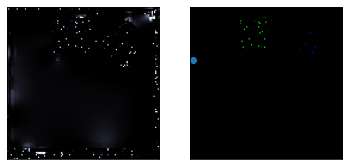

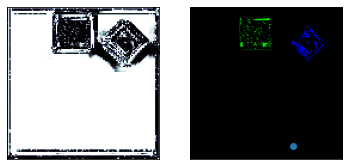

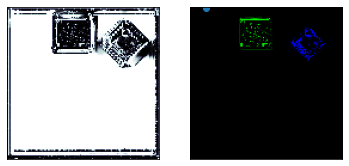

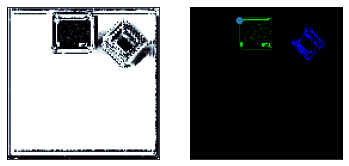

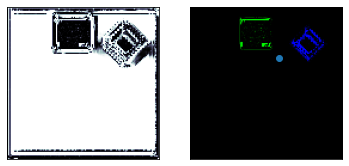

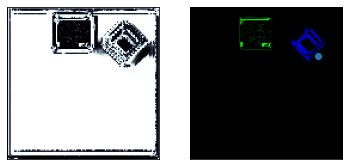

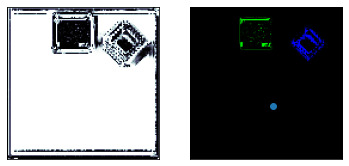

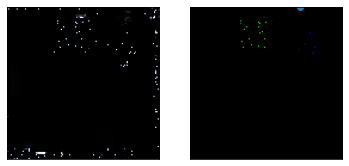

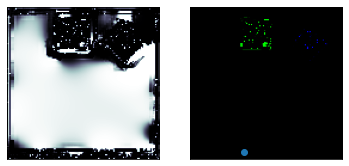

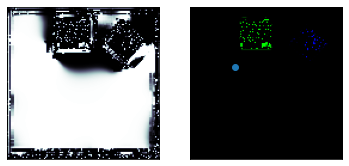

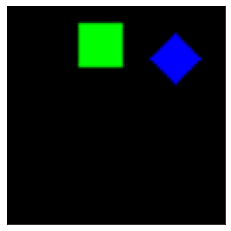

In [376]:

level_masks = outputs["masks"]
level_index = outputs["level_index"]
level_inds = outputs["level_index"]
level_features = outputs["level_features"]

for level in level_masks:print(level.shape)

for idx in level_index:print(idx)

for feat in level_features:print(feat.shape)


base_locs = level_index[0]
base_mask = level_masks[0].reshape([10,128,128]).detach()
print(base_mask.max())

for i in range(base_mask.shape[0]):
    plt.subplot(1, 2, 1);plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False);
    plt.imshow(base_mask[i], cmap="bone")
    plt.subplot(1, 2, 2);plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False);

    plt.imshow(base_mask[i].unsqueeze(-1) * ims[0])
    bx = base_locs[i] / 128
    by = base_locs[i] % 128
    plt.scatter(bx,by)
    plt.pause(0.01)
plt.show()

for b in range(B):
    plt.subplot(1, B, b + 1);plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False); plt.imshow(ims[b,:,:,:])
plt.show()

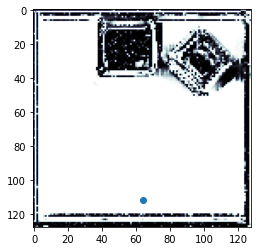

In [386]:
base_features = level_features[0]

location = (0,0)
idx = location[0] * 128 + location[1]

sample_features = base_features[idx:idx+1]

masks = torch.sigmoid(
                (torch.matmul(sample_features, base_features.permute(1,0)) - 0.25) / 0.02
                ).reshape([1,128,128])

plt.imshow(masks[0].detach().numpy(), cmap = "bone")
plt.scatter(location[0], location[1])
plt.show()


In [387]:
base_features = level_features[0]

for i in range(128):
    for j in range(128):
        location = (i,j)
        idx = location[0] * 128 + location[1]

        sample_features = base_features[idx:idx+1]

        masks = torch.sigmoid(
                (torch.matmul(sample_features, base_features.permute(1,0)) - 0.25) / 0.02
                ).reshape([1,128,128])

        plt.imshow(masks[0].detach().numpy(), cmap = "bone")
        plt.scatter(location[0], location[1])
        plt.show()